<a href="https://colab.research.google.com/github/luismoretaplus/ProyectoPLN/blob/main/ExploracionDatos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Instalación y carga de librerías

In [1]:
pip install gensim

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, re, sys, unicodedata, textwrap, math
from collections import Counter
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
import gensim
from gensim.models import Word2Vec
from scipy.sparse import csr_matrix, hstack
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
pd.set_option("display.max_colwidth", 200)
plt.rcParams["figure.figsize"] = (10, 5)

## 1) Cargar datos de forma robusta

In [4]:
# === 1) Cargar datos (robusto a encoding/ruido) ===
PATH = '/content/drive/MyDrive/ProyectoPLN/train.csv'

def load_table(path, sep=None):
    """
    Intenta leer el archivo con varias configuraciones de separador/encoding.
    Devuelve un DataFrame o lanza el último error.
    """
    encodings = ["utf-8", "utf-8-sig", "latin-1", "cp1252"]
    seps = [sep] if sep else [",", "\t", ";", "|"]
    last_err = None
    for enc in encodings:
        for s in seps:
            try:
                df = pd.read_csv(path, sep=s, encoding=enc, on_bad_lines="skip", engine="python")
                return df
            except Exception as e:
                last_err = e
    raise last_err

train_df = load_table(PATH)
print(train_df.shape)
train_df.head()


(31403, 2)


,text,decade
0,"\nHonorarias ¡jubiladas. 57 \ndit.ad Pontem de poreft.Proreg.118,3, $.9.M.-70 \npag.4.1. 3 Ste ph.Gratian. difcept.291, áqu len \nnes parece que aísilte, O ayuda Calsiodoro \nlib,6.epuft.s 2.Donde...",164
1,"gone. Sus amigos , sus clientes, todo \ncuanto le rodea le prueban que es hom- \nbre de mucha importancia. Si ve que al- \ngunos hombre» plebeyos á fuerza de ser- \nvicios y de hazañas se elevan d...",182
2,"Prefosen quemanera,e per qualesfolpechas deuan feratormentados, e \nante quien,e quie preguntasles deuan hazer mientras los tormentarf, \nvecla.lstitopuzo",157
3,"Caistro el M a y o r a i .] Del apellido de Cañroíe \nvalió Don Luis enefta. Metáfora, para el nombre que fupo \nne de Caiftro. Mayoral fe llama entre los ganaderos e...",163
4,"\nlos que panden macho ; y \notros en la fu ña abundan¬ \ncia , íiempre viuen como \nmendigos. La Lana aun en \nel edito fagrado compite \ncon el Sol luzimieutos,' \npues ...",166


In [5]:
train_df.sample(5, random_state=42)

,text,decade
11265,"— Levanta, hija mia, repuso el supuesto fraile: ¿quién \neres, dime, que andas sola por estos despoblados?",183
27517,"13. Item mando que en la dicha mi villa de Co- \nyoacan se edifique y haga un colegio para estudiantes \nque estudien teología y derecho canónico para qae ha- \nya (*""] p...",184
5925,"mente. La fegunda , de lo que oyeron dezir. La ter- \ncera , de lo que creen fobre aquel fecho de que les \npreguntan, fi es afsi , o non. Pero li el Rey ouicre de \nt'a...",175
3776,"dades De Dentro a fuera, y pozqelfolre^ Bueiroís Deía l?^enia Del l?ueuo/ q Da ti \nfuelue mucl?as parres De Ijuinedadfupa- so ínáreníiníéto al cuerpo/quáto día pe^ \nfl:iaDela cera/que la l^ajenp...",154
29573,"ESPERIENCI A.Lat.experien \ntia,es el conocimiento y noticia de algu \nna cofa q fe ha fabido por vfo, prouádo \nla, y. experimentándola, fin enfeñamien \nto de otro, defalir ci...",161


## 2) Derivar etiquetas legibles (década y siglo)

In [6]:
# === 2) Etiquetas humanas ===
train_df["decade_label"] = train_df["decade"].astype(int).astype(str) + "0s"
train_df["year_start"]  = train_df["decade"] * 10
train_df["year_end"]    = train_df["decade"] * 10 + 9
# Siglo aproximado: 1600-1699 -> siglo 17, etc.
train_df["century"] = (train_df["year_start"] // 100) + 1

train_df[["text", "decade", "decade_label", "century"]].head()


,text,decade,decade_label,century
0,"\nHonorarias ¡jubiladas. 57 \ndit.ad Pontem de poreft.Proreg.118,3, $.9.M.-70 \npag.4.1. 3 Ste ph.Gratian. difcept.291, áqu len \nnes parece que aísilte, O ayuda Calsiodoro \nlib,6.epuft.s 2.Donde...",164,1640s,17
1,"gone. Sus amigos , sus clientes, todo \ncuanto le rodea le prueban que es hom- \nbre de mucha importancia. Si ve que al- \ngunos hombre» plebeyos á fuerza de ser- \nvicios y de hazañas se elevan d...",182,1820s,19
2,"Prefosen quemanera,e per qualesfolpechas deuan feratormentados, e \nante quien,e quie preguntasles deuan hazer mientras los tormentarf, \nvecla.lstitopuzo",157,1570s,16
3,"Caistro el M a y o r a i .] Del apellido de Cañroíe \nvalió Don Luis enefta. Metáfora, para el nombre que fupo \nne de Caiftro. Mayoral fe llama entre los ganaderos e...",163,1630s,17
4,"\nlos que panden macho ; y \notros en la fu ña abundan¬ \ncia , íiempre viuen como \nmendigos. La Lana aun en \nel edito fagrado compite \ncon el Sol luzimieutos,' \npues ...",166,1660s,17


## 3) Balance de clases

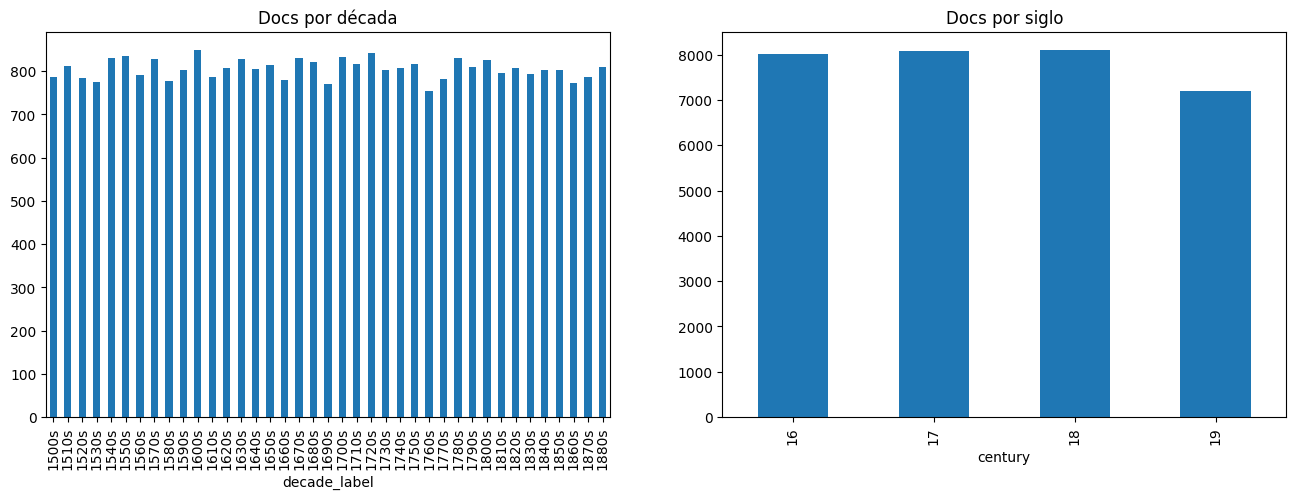

,count
count,39.000000
mean,805.205128
std,22.058749
min,754.000000
25%,787.000000
50%,807.000000
75%,823.500000
max,848.000000


In [7]:
# === 3) Distribución por década y por siglo ===
dec_counts = train_df["decade_label"].value_counts().sort_index()
cent_counts = train_df["century"].value_counts().sort_index()

fig, ax = plt.subplots(1,2, figsize=(16,5))
dec_counts.plot(kind="bar", ax=ax[0], title="Docs por década")
cent_counts.plot(kind="bar", ax=ax[1], title="Docs por siglo")
plt.show()

dec_counts.describe()


## 4) Longitud de documentos (caracteres y tokens simples)

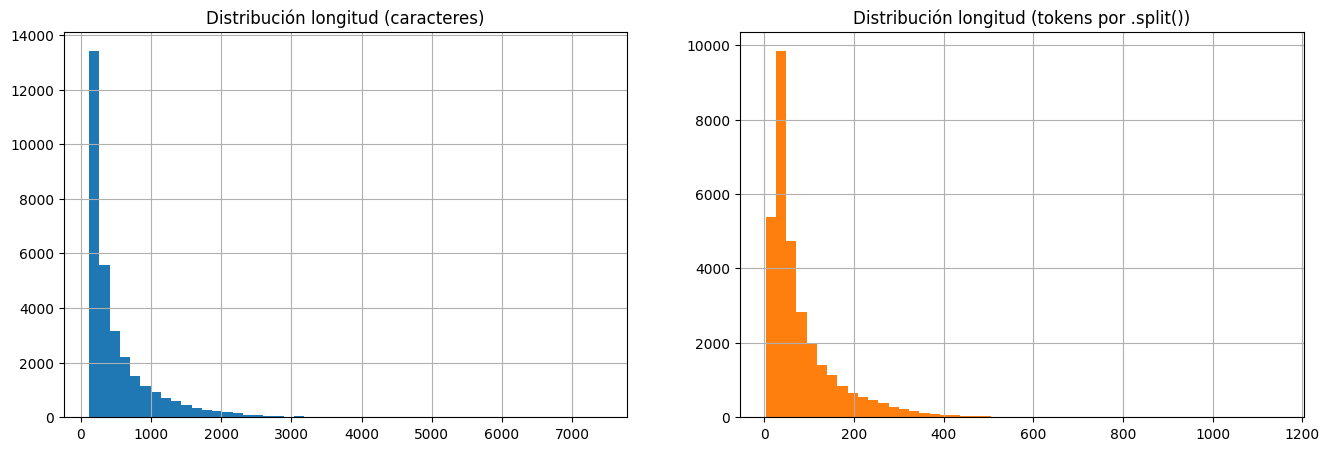

,chars,tokens
min,120.00000,3.00000
median,315.00000,50.00000
mean,520.56829,82.28319
p95,1627.00000,255.00000
max,7418.00000,1146.00000


In [8]:
# === 4) Longitud de documentos ===
def simple_length_stats(df, text_col="text"):
    lengths_chars = df[text_col].astype(str).str.len()
    lengths_tokens = df[text_col].astype(str).str.split().map(len)

    fig, ax = plt.subplots(1,2, figsize=(16,5))
    lengths_chars.hist(ax=ax[0], bins=50)
    ax[0].set_title("Distribución longitud (caracteres)")
    lengths_tokens.hist(ax=ax[1], bins=50, color="tab:orange")
    ax[1].set_title("Distribución longitud (tokens por .split())")
    plt.show()

    return pd.DataFrame({
        "chars": [lengths_chars.min(), lengths_chars.median(), lengths_chars.mean(), lengths_chars.quantile(0.95), lengths_chars.max()],
        "tokens": [lengths_tokens.min(), lengths_tokens.median(), lengths_tokens.mean(), lengths_tokens.quantile(0.95), lengths_tokens.max()],
    }, index=["min","median","mean","p95","max"])

length_table = simple_length_stats(train_df, "text")
length_table

In [9]:
length_table

,chars,tokens
min,120.00000,3.00000
median,315.00000,50.00000
mean,520.56829,82.28319
p95,1627.00000,255.00000
max,7418.00000,1146.00000


## 5) Inventario de caracteres y no-ASCII

In [10]:
# === 5) Inventario de caracteres ===
def char_inventory(series, topk=100):
    counter = Counter()
    total_chars = 0
    for s in series.astype(str):
        counter.update(s)
        total_chars += len(s)
    df_chars = pd.DataFrame(counter.most_common(topk), columns=["char","freq"])
    df_chars["share_%"] = (df_chars["freq"] / total_chars) * 100
    return df_chars, total_chars

chars_df, total_chars = char_inventory(train_df["text"], topk=100)
display(chars_df.head(30))

# No ASCII
def non_ascii_inventory(series, topk=100):
    counter = Counter()
    for s in series.astype(str):
        for ch in s:
            if ord(ch) > 127:
                counter[ch] += 1
    df = pd.DataFrame(counter.most_common(topk), columns=["char","freq"])
    return df

non_ascii_df = non_ascii_inventory(train_df["text"], topk=100)
display(non_ascii_df.head(30))


,char,freq,share_%
0,,3680752,22.515817
1,e,1388809,8.495593
2,a,1253826,7.669877
3,o,1007492,6.163008
4,i,759153,4.643874
5,r,725389,4.437334
6,n,723229,4.424121
7,l,644277,3.941157
8,s,559917,3.425112
9,d,541261,3.310990


,char,freq
0,í,106291
1,á,52735
2,ó,51714
3,é,38273
4,ñ,25942
5,»,10596
6,ú,9426
7,¿,8255
8,«,6886
9,¡,6369


## 6) Señales de OCR/ruido y símbolos “raros”

In [11]:
# === 6) Heurísticas de ruido OCR y símbolos ===
patterns = {
    "saltos_linea_literal": r"\\n",                      # secuencias \n literales
    "múltiples_espacios": r"\s{2,}",                     # 2 o más espacios
    "guion_corte_linea": r"[A-Za-z]-\s*\n\s*[A-Za-z]",   # palabra- \n palabra
    "espacios_inter_letra": r"(?:\b(?:[A-Za-z]\s){2,}[A-Za-z]\b)", # M a y o r
    "puntuación_doble": r"(?:[.,;:!?]){2,}",             # ..  ;;  !!
}

def count_pattern(series, regex):
    c = 0
    for s in series.astype(str):
        c += len(re.findall(regex, s, flags=re.MULTILINE))
    return c

ocrs = {name: count_pattern(train_df["text"], pat) for name, pat in patterns.items()}
pd.Series(ocrs).sort_values(ascending=False)


,0
múltiples_espacios,1375809
guion_corte_linea,48189
puntuación_doble,7370
espacios_inter_letra,789
saltos_linea_literal,49


## Preprocesamiento de datos

In [12]:
import re
import unicodedata
from typing import Iterable, Optional, Set, Pattern

# Compilamos patrones de regex UNA VEZ para eficiencia
_RE_DEHYPHEN = re.compile(r"-\s*\n\s*")         # une palabras cortadas por guion + salto de línea
_RE_WS = re.compile(r"\s+")                     # colapsa cualquier espacio en blanco a ' '
# Patrones NUEVOS para correcciones específicas de OCR
_RE_OCR_NOISE = re.compile(r'[\\^?:*\[\]\(\)\|;]') # Caracteres de ruido comúnmente introducidos por OCR
_RE_OCR_F_TO_S = re.compile(r'\bf([aeiouáéíóú])')   # Patrón: 'f' al inicio de palabra seguida de vocal -> 's'
_RE_OCR_LT_TO_T = re.compile(r'\blt\b')            # Intenta capturar errores comunes 'lt' por 't' o similar
# Soft hyphen (ASCII no imprimible de corte)
_SOFT_HYPHEN = "\u00AD"

# Símbolos “no lingüísticos” comunes de OCR/maquetación (EXPANDIDO)
DEFAULT_ARTIFACTS: Set[str] = {
    "■", "•", "¬", "©", "®", "€", "£",  # Símbolos de maquetación
    "§", "¶", "‡", "†", "÷", "¿", "¡",   # Símbolos tipográficos varios
    "~", "_", "{", "}", "<", ">",         # Caracteres usados como decoración o marcadores
    "”", "“", "”", "‘", "’",              # Comillas inteligentes (a veces mal escaneadas)
}

def normalize_historic_text(
    text: str,
    *,
    remove_artifacts: bool = True,
    artifacts: Optional[Iterable[str]] = None,
    dehyphenate: bool = True,
    collapse_spaces: bool = True,
    map_long_s_to_s: bool = True,  # ACTIVADO por defecto. Crucial para OCR antiguo.
    correct_common_ocr_errors: bool = True,  # NUEVO: Nuestra corrección específica
) -> str:
    """
    Normalización AGRESIVA consciente de artefactos de OCR en textos históricos.

    - NFKC Unicode normalization.
    - Eliminación de ruido de OCR característico (^, ?, :, *, etc.).
    - Correcciones heurísticas basadas en patrones comunes de error (f->s, lt->t, etc.).
    - Dehyphenation y eliminación de soft hyphens.
    - Eliminación de artefactos de OCR/maquetación.
    - Mapeo de ſ (s larga) → s.
    - Colapso de espacios.

    NOTA: Esta función es más intrusiva y está orientada a limpiar OCR sucio.
    """
    if not isinstance(text, str):
        text = str(text)

    # 1) Unicode NFKC (el primer paso, crucial para normalizar diacríticos)
    s = unicodedata.normalize("NFKC", text)

    # 2) (NUEVO) Eliminación temprana de ruido de OCR genérico
    # Esto quita caracteres que casi nunca son lingüísticos
    if correct_common_ocr_errors:
        s = _RE_OCR_NOISE.sub(' ', s)  # Reemplazar ruido con espacio

    # 3) Dehyphenation (importante hacerlo antes de correcciones que puedan crear guiones)
    if dehyphenate:
        s = _RE_DEHYPHEN.sub("", s)
        s = s.replace(_SOFT_HYPHEN, "")

    # 4) (NUEVO) Correcciones heurísticas específicas de OCR
    if correct_common_ocr_errors:
        # Corrección MASIVA: 'f' seguida de vocal al inicio de palabra -> 's' (muy común)
        #s = _RE_OCR_F_TO_S.sub(r's\1', s)
        # Otras correcciones basadas en los ejemplos proporcionados
        s = re.sub(r'\bmucl?as\b', 'muchas', s)   # 'mucl?as' -> 'muchas'
        s = re.sub(r'\bdefalir\b', 'de salir', s) # 'defalir' -> 'de salir'
        s = re.sub(r'\bpefquifa\b', 'pesquisa', s) # 'pefquifa' -> 'pesquisa'
        s = re.sub(r'\bfolre\^', 'sobre', s)      # 'folre^' -> 'sobre'
        # Corrección general: 'c' por 'e' en contextos como "Euangelio"
        s = re.sub(r'(\w)c(\w)', r'\1e\2', s)     # Intenta corregir 'euangclio' -> 'evangelio'
        # Intenta corregir uniones incorrectas de palabras
        s = re.sub(r'([a-z0-9])([A-ZÁÉÍÓÚ])', r'\1 \2', s)

    # 5) (Opcional) eliminar artefactos de OCR/maquetación
    if remove_artifacts:
        arts = set(artifacts) if artifacts is not None else DEFAULT_ARTIFACTS
        if arts:
            cls = "[" + "".join(re.escape(ch) for ch in sorted(arts)) + "]"
            s = re.sub(cls, "", s)

    # 6) Mapeo de ſ (s larga) → s (MUY importante para textos antiguos digitalizados)
    if map_long_s_to_s:
        s = s.replace("ſ", "s").replace("ƨ", "s")

    # 7) Colapsar espacios (incluye \n, \t, etc.) a un único espacio
    if collapse_spaces:
        s = _RE_WS.sub(" ", s).strip()

    return s


# --- TEST con tus ejemplos ---
test_cases = [
    "mente. La fegunda , de lo que oyeron dezir.",
    "dades De Dentro a fuera, y pozqelfolre^ Bueiroís Deía l?^enia Del l?ueuo/ q Da ti fuelue mucl?as parres De Ijuinedadfupa- so ínáreníiníéto al cuerpo/quáto día pe^ fl:iaDela cera/que la l^ajenparef...",
    "ESPERIENCI A.Lat.experien tia,es el conocimiento y noticia de algu na cofa q fe ha fabido por vfo, prouádo la, y. experimentándola, fin enfeñamien to de otro, defalir cierta en muchospar ticulares...",
    "Dexoel deíierto por acudir al prouecho publico, y particular del próximo , y dio principio á la predicación del Euangclio fantc, cum** piicndocfonlasheroycas virtudes de lacandad, y miiericordiaqu..."
]

print("=== PRUEBAS DE NORMALIZACIÓN MEJORADA ===")
for i, original_text in enumerate(test_cases):
    print(f"\n--- Ejemplo {i+1} ---")
    print("ORIGINAL:    ", original_text)
    cleaned = normalize_historic_text(original_text, correct_common_ocr_errors=True)
    print("LIMPIO:      ", cleaned)

=== PRUEBAS DE NORMALIZACIÓN MEJORADA ===

--- Ejemplo 1 ---
ORIGINAL:     mente. La fegunda , de lo que oyeron dezir.
LIMPIO:       mente. La fegunda , de lo que oyeron dezir.

--- Ejemplo 2 ---
ORIGINAL:     dades De Dentro a fuera, y pozqelfolre^ Bueiroís Deía l?^enia Del l?ueuo/ q Da ti fuelue mucl?as parres De Ijuinedadfupa- so ínáreníiníéto al cuerpo/quáto día pe^ fl:iaDela cera/que la l^ajenparef...
LIMPIO:       dades De Dentro a fuera, y pozqelfolre Bueiroís Deía l enia Del l ueuo/ q Da ti fuelue muel as parres De Ijuinedadfupa- so ínáreníiníéto al cuerpo/quáto día pe fl ia Dela cera/que la l ajenparef...

--- Ejemplo 3 ---
ORIGINAL:     ESPERIENCI A.Lat.experien tia,es el conocimiento y noticia de algu na cofa q fe ha fabido por vfo, prouádo la, y. experimentándola, fin enfeñamien to de otro, defalir cierta en muchospar ticulares...
LIMPIO:       ESPERIENCI A.Lat.experien tia,es el conoeimiento y notieia de algu na cofa q fe ha fabido por vfo, prouádo la, y. experimentándola,

In [25]:
display(train_df)


,text,decade,decade_label,year_start,year_end,century,normalized_text,processed_text
0,"\nHonorarias ¡jubiladas. 57 \ndit.ad Pontem de poreft.Proreg.118,3, $.9.M.-70 \npag.4.1. 3 Ste ph.Gratian. difcept.291, áqu len \nnes parece que aísilte, O ayuda Calsiodoro \nlib,6.epuft.s 2.Donde...",164,1640s,1640,1649,17,"Honorarias jubiladas. 57 dit.ad Pontem de poreft.Proreg.118,3, $.9.M.-70 pag.4.1. 3 Ste ph.Gratian. difeept.291, áqu len nes pareee que aísilte, O ayuda Calsiodoro lib,6.epuft.s 2.Donde llama Oelo...","honorarias jubiladas. dit.ad pontem de poreft.proreg. , , . .m.- pag. . . ste ph.gratian. difeept. , áqu len nes pareee que aísilte, o ayuda calsiodoro lib, .epuft.s .donde llama oeloso cingv- y"
1,"gone. Sus amigos , sus clientes, todo \ncuanto le rodea le prueban que es hom- \nbre de mucha importancia. Si ve que al- \ngunos hombre» plebeyos á fuerza de ser- \nvicios y de hazañas se elevan d...",182,1820s,1820,1829,19,"gone. Sus amigos , sus clientes, todo cuanto le rodea le prueban que es hombre de mueha importaneia. Si ve que algunos hombre» plebeyos á fuerza de servieios y de hazañas se elevan de la clase en ...","gone. sus amigos , sus clientes, todo cuanto le rodea le prueban que es hombre de mueha importaneia. si ve que algunos hombre plebeyos á fuerza de servieios y de hazañas se elevan de la clase en q..."
2,"Prefosen quemanera,e per qualesfolpechas deuan feratormentados, e \nante quien,e quie preguntasles deuan hazer mientras los tormentarf, \nvecla.lstitopuzo",157,1570s,1570,1579,16,"Prefosen quemanera,e per qualesfolpeehas deuan feratormentados, e ante quien,e quie preguntasles deuan hazer mientras los tormentarf, veela.lstitopuzo","prefosen quemanera,e per qualesfolpeehas deuan feratormentados, e ante quien,e quie preguntasles deuan hazer mientras los tormentarf, veela.lstitopuzo"
3,"Caistro el M a y o r a i .] Del apellido de Cañroíe \nvalió Don Luis enefta. Metáfora, para el nombre que fupo \nne de Caiftro. Mayoral fe llama entre los ganaderos e...",163,1630s,1630,1639,17,"Caistro el M a y o r a i . Del apellido de Cañroíe valió Don Luis enefta. Metáfora, para el nombre que fupo ne de Caiftro. Mayoral fe llama entre los ganaderos el que tiene el primer lugar, y a qu...","caistro el m a y o r a i . del apellido de cañroíe valió don luis enefta. metáfora, para el nombre que fupo ne de caiftro. mayoral fe llama entre los ganaderos el que tiene el primer lugar, y a qu..."
4,"\nlos que panden macho ; y \notros en la fu ña abundan¬ \ncia , íiempre viuen como \nmendigos. La Lana aun en \nel edito fagrado compite \ncon el Sol luzimieutos,' \npues ...",166,1660s,1660,1669,17,"los que panden maeho y otros en la fu ña abundan cia , íiempre viuen como mendigos. La Lana aun en el edito fagrado compite con el Sol luzimieutos,' pues a los dos los llama Moy fes Aftros de clar...","los que panden maeho y otros en la fu ña abundan cia , íiempre viuen como mendigos. la lana aun en el edito fagrado compite con el sol luzimieutos, pues a los dos los llama moy fes aftros de clari..."
...,...,...,...,...,...,...,...,...
31398,"N | Ml Luce Ll... ree de ha Ja ae e] bsupk : \nA 2 (AP. 23. DELA Q0VENTA QVE ADETO: \nX ' I ll ar Dios envazon de las idolatrias de los Indios a los 3 00 \n2 5 facerdoses, por efle sitwlo de facer...",164,1640s,1640,1649,17,"N Ml Luee Ll... ree de ha Ja ae e bsupk A 2 AP. 23. DELA Q0 VENTA QVE ADETO X ' I ll ar Dios envazon de las idolatrias de los Indios a los 3 00 2 5 faeerdoses, por efle sitwlo de faeerdotes.","n ml luee ll... ree de ha ja ae e bsupk a ap. . dela q venta qve adeto x i ll ar dios envazon de las idolatrias de los indios a los faeerdoses, por efle sitwlo de faeerdotes."
31399,"Haz que feas primero y tomar quiera ^ \nLafegundaquiftionel Africanoy \nY no dudes que yo boluer me quiera. \nQue a ti refponderc y a todo humano. \nRuger.grit6,No quieroquc...",155,1550s,1550,1559,16,"Haz que feas primero y tomar quiera Lafegundaquiftionel Afrieanoy Y no dudes que yo boluer me quiera. Que a ti refpon

In [13]:
# Apply the normalization function and create a new column
train_df["normalized_text"] = train_df["text"].apply(normalize_historic_text)

# Display a sample of the original and normalized text
display(train_df[["text", "normalized_text"]].sample(10, random_state=42))

,text,normalized_text
11265,"— Levanta, hija mia, repuso el supuesto fraile: ¿quién \neres, dime, que andas sola por estos despoblados?","— Levanta, hija mia, repuso el supuesto fraile quién eres, dime, que andas sola por estos despoblados"
27517,"13. Item mando que en la dicha mi villa de Co- \nyoacan se edifique y haga un colegio para estudiantes \nque estudien teología y derecho canónico para qae ha- \nya (*""] p...","13. Item mando que en la dieha mi villa de Coyoaean se edifique y haga un colegio para estudiantes que estudien teología y dereeho canónieo para qae haya "" personas doetas en la Nueva España que r..."
5925,"mente. La fegunda , de lo que oyeron dezir. La ter- \ncera , de lo que creen fobre aquel fecho de que les \npreguntan, fi es afsi , o non. Pero li el Rey ouicre de \nt'a...","mente. La fegunda , de lo que oyeron dezir. La tereera , de lo que creen fobre aquel feeho de que les preguntan, fi es afsi , o non. Pero li el Rey ouiere de t'azer la pesquisa , puédeles tomar ju..."
3776,"dades De Dentro a fuera, y pozqelfolre^ Bueiroís Deía l?^enia Del l?ueuo/ q Da ti \nfuelue mucl?as parres De Ijuinedadfupa- so ínáreníiníéto al cuerpo/quáto día pe^ \nfl:iaDela cera/que la l^ajenp...","dades De Dentro a fuera, y pozqelfolre Bueiroís Deía l enia Del l ueuo/ q Da ti fuelue muel as parres De Ijuinedadfupa- so ínáreníiníéto al cuerpo/quáto día pe fl ia Dela cera/que la l ajenparefee..."
29573,"ESPERIENCI A.Lat.experien \ntia,es el conocimiento y noticia de algu \nna cofa q fe ha fabido por vfo, prouádo \nla, y. experimentándola, fin enfeñamien \nto de otro, defalir ci...","ESPERIENCI A.Lat.experien tia,es el conoeimiento y notieia de algu na cofa q fe ha fabido por vfo, prouádo la, y. experimentándola, fin enfeñamien to de otro, de salir cierta en muehospar tieulare..."
17125,"Dexoel deíierto por acudir al prouecho publico, y particular del \npróximo , y dio principio á la predicación del Euangclio fantc, cum** \npiicndocfonlasheroycas virtudes de ...","Dexoel deíierto por aeudir al proueeho publieo, y partieular del próximo , y dio prineipio á la predieación del Euangelio fantc, cum piiendoefonlasheroyeas virtudes de laeandad, y miierieordiaque ..."
9384,"el primer inflante de fu Concepción : y que la que de pies a cabera eíU vellida del So! , no pudo \ntener en fu perfonala mas mínima fombra de culpa.","el primer inflante de fu Coneepeión y que la que de pies a cabera eíU vellida del So! , no pudo tener en fu perfonala mas mínima fombra de culpa."
18973,"\nida cion Quan | \nDize, que nn Jue rd Ya queen: el golfo viab, \nPEA So no zocobrar adrede >» \n_ Donde Le falto: Jos AY ME pigto entrar en: elpuerio! \n—Sinlos pueltos consententes, - Amorit e ...","ida cion Quan Dize, que nn Jue rd Ya queen el golfo viab, PEA So no zoeobrar adrede » Donde Le falto Jos AY ME pigto entrar en elpuerio! —Sinlos pueltos consententes, - Amorit e moquisdu Loslanees..."
12085,"ítem rebrá informado contra los provincials que volunta- \nriament aurán portat viures al enemich, tant en lo siti de \nConstantí com en Tarragona ya altres llochs que lo ...","ítem rebrá informado contra los provineials que voluntariament aurán portat viures al enemieh, tant en lo siti de Constantí com en Tarragona ya altres lloehs que lo enemieh tindrá oeupats del camp..."
19139,por la Religión de los Carmelitas Descalzos reunidos en Capítulo \nen el monasterio de San Pedro de Pastrana el 27 de Octubre del \nmismo año.,por la Religión de los Carmelitas Desealzos reunidos en Capítulo en el monasterio de San Pedro de Pastrana el 27 de Oetubre del mismo año.


## Preprocesamiento de datos completa

In [14]:

# === 3) PREPROCESAMIENTO MEJORADO ===
# (Usaremos tu excelente función de normalización)
# === 3) PREPROCESAMIENTO MEJORADO (VERSIÓN PARA OCR) ===
def preprocess_text(text, language='spanish'):
    """
    Preprocesamiento específico para texto histórico con OCR sucio.
    Prioriza la corrección de artefactos sobre la limpieza lingüística tradicional.
    """
    # 1. Normalización histórica AGRESIVA (nuestra función mejorada)
    text = normalize_historic_text(text, remove_artifacts=True, correct_common_ocr_errors=True)

    # 2. Convertir a minúsculas (¡DESPUÉS de la corrección OCR!)
    text = text.lower()

    # 3. Eliminación de caracteres NO alfabéticos (mucho más permisiva)
    # Permitimos letras, espacios, y signos de puntuación básicos .,;:!?¿¡-
    # Esto evita que rompamos palabras parcialmente corregidas
    text = re.sub(r'[^a-záéíóúñüç\s.,;:!?¿¡-]', ' ', text)

    # 4. Tokenización simple
    words = text.split()

    # 5. Eliminación de stopwords (pero con CAUTELA)
    # En textos históricos, algunas "stopwords" pueden ser cruciales para la datación.
  #  if language == 'spanish':
  #      stop_words = set(stopwords.words('spanish'))
        # Podemos considerar NO eliminar stopwords, o eliminar solo las más comunes
        # words = [word for word in words if word not in stop_words and len(word) > 2]
  #      words = [word for word in words if len(word) > 2] # Prueba SIN quitar stopwords

    # 6. Stemming/Lemmatization (PROBABLEMENTE DAÑINO)
    # NO hacer stemming. Destruiría la señal temporal que acabamos de recuperar.
    # Ej: "dezir" (antiguo) y "decir" (moderno) se stemmean igual, perdiendo la diferencia temporal.
    # stemmer = SnowballStemmer('spanish')
    # words = [stemmer.stem(word) for word in words]

    return ' '.join(words)

# Probar el preprocesamiento completo con un ejemplo
print("\n=== PREPROCESAMIENTO COMPLETO ===")
sample = test_cases[1] # Un ejemplo complejo
print("Original: ", sample)
preprocessed = preprocess_text(sample)
print("Preprocesado: ", preprocessed)


=== PREPROCESAMIENTO COMPLETO ===
Original:  dades De Dentro a fuera, y pozqelfolre^ Bueiroís Deía l?^enia Del l?ueuo/ q Da ti fuelue mucl?as parres De Ijuinedadfupa- so ínáreníiníéto al cuerpo/quáto día pe^ fl:iaDela cera/que la l^ajenparef...
Preprocesado:  dades de dentro a fuera, y pozqelfolre bueiroís deía l enia del l ueuo q da ti fuelue muel as parres de ijuinedadfupa- so ínáreníiníéto al cuerpo quáto día pe fl ia dela cera que la l ajenparef...


In [26]:

# Aplicar preprocesamiento a una muestra para probar
sample_text = train_df['normalized_text'].iloc[0]
print(f"Texto original: {sample_text}")
print(f"Texto procesado: {preprocess_text(sample_text)}")

# Aplicar a todo el dataset (¡esto puede tomar tiempo!)
print("\nPreprocesando textos...")
train_df['processed_text'] = train_df['normalized_text'].apply(preprocess_text)
print("Preprocesamiento completado.")

Texto original: Honorarias jubiladas. 57 dit.ad Pontem de poreft.Proreg.118,3, $.9.M.-70 pag.4.1. 3 Ste ph.Gratian. difeept.291, áqu len nes pareee que aísilte, O ayuda Calsiodoro lib,6.epuft.s 2.Donde llama Oeloso CINGV- y 19
Texto procesado: honorarias jubiladas. dit.ad pontem de poreft.proreg. , , . .m.- pag. . . ste ph.gratian. difeept. , áqu len nes pareee que aísilte, o ayuda calsiodoro lib, .epuft.s .donde llama oeloso cingv- y

Preprocesando textos...
Preprocesamiento completado.


## FEATURE ENGINEERING AVANZADO

In [ ]:

# # === 4) FEATURE ENGINEERING AVANZADO ===
# class MetaFeaturesExtractor(BaseEstimator, TransformerMixin):
#     """
#     Extractor de características meta del texto.
#     """
#     def fit(self, X, y=None):
#         return self

#     def transform(self, X, y=None):
#         features = []
#         for text in X:
#             # Longitud promedio de las palabras
#             words = text.split()
#             avg_word_length = np.mean([len(word) for word in words]) if words else 0

#             # Ratio de unique words (riqueza léxica)
#             unique_ratio = len(set(words)) / len(words) if words else 0

#             # Conteo de signos de puntuación (aproximado)
#             punctuation_count = sum(1 for char in text if char in '.,;:!?')

#             features.append([avg_word_length, unique_ratio, punctuation_count])

#         return np.array(features)



## VECTORIZACIÓN HÍBRIDA (TF-IDF + Word2Vec + Meta Features)

In [ ]:
# # === 5) VECTORIZACIÓN HÍBRIDA (TF-IDF + Word2Vec + Meta Features) ===
# # Preparar datos para Word2Vec
# sentences = [text.split() for text in train_df['processed_text']]

# # Entrenar modelo Word2Vec
# print("Entrenando modelo Word2Vec...")
# w2v_model = Word2Vec(
#     sentences=sentences,
#     vector_size=100,    # Dimensionalidad de los vectores
#     window=5,           # Contexto alrededor de la palabra
#     min_count=2,        # Ignorar palabras muy raras
#     workers=4,          # Núcleos de CPU a usar
#     epochs=10           # Iteraciones sobre el corpus
# )
# print("Word2Vec entrenado.")

# # Función para promediar vectores de palabras de un texto
# def document_vector(word_list, model):
#     # Filtrar palabras que están en el vocabulario de Word2Vec
#     words = [word for word in word_list if word in model.wv.key_to_index]
#     if len(words) == 0:
#         return np.zeros(model.vector_size)
#     # Promediar los vectores de todas las palabras
#     return np.mean(model.wv[words], axis=0)

# # Crear matriz de características Word2Vec
# print("Creando características Word2Vec...")
# w2v_features = np.array([document_vector(text.split(), w2v_model)
#                          for text in train_df['processed_text']])

# # Crear características TF-IDF
# print("Creando características TF-IDF...")
# tfidf_vectorizer = TfidfVectorizer(
#     max_features=5000,
#     ngram_range=(1, 3),           # Incluir unigramas, bigramas y trigramas
#     min_df=3,                     # Ignorar términos muy raros
#     max_df=0.85                   # Ignorar términos muy comunes
# )
# tfidf_features = tfidf_vectorizer.fit_transform(train_df['processed_text'])

# # Crear características meta
# print("Creando características meta...")
# meta_extractor = MetaFeaturesExtractor()
# meta_features = meta_extractor.transform(train_df['processed_text'])

# # Combinar todas las características
# print("Combinando todas las características...")
# X_combined = hstack([tfidf_features, csr_matrix(w2v_features), csr_matrix(meta_features)])
# y = train_df['decade'].values

# print(f"Matriz final de características: {X_combined.shape}")

In [27]:
# === 4) FEATURE ENGINEERING AVANZADO (MEJORADO) ===
class MetaFeaturesExtractor(BaseEstimator, TransformerMixin):
    """
    Extractor de características meta del texto con métricas mejoradas.
    """
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        features = []
        for text in X:
            words = text.split()
            char_count = len(text)
            word_count = len(words)

            # Características básicas
            avg_word_length = np.mean([len(word) for word in words]) if words else 0
            unique_ratio = len(set(words)) / word_count if word_count else 0

            # Nuevas características basadas en el diagnóstico
            # 1. Densidad de puntuación (normalizada por longitud)
            punctuation_chars = sum(1 for char in text if char in '.,;:!?¿¡')
            punctuation_density = punctuation_chars / char_count if char_count else 0

            # 2. Longitud del documento (chars y words)
            # 3. Proporción de palabras largas (>6 caracteres) - indicador de complejidad
            long_words_ratio = sum(1 for word in words if len(word) > 6) / word_count if word_count else 0

            # 4. Proporción de dígitos (puede indicar documentos técnicos/históricos)
            digit_ratio = sum(1 for char in text if char.isdigit()) / char_count if char_count else 0

            features.append([
                avg_word_length,
                unique_ratio,
                punctuation_density,
                np.log1p(char_count),  # Usar log para normalizar la cola larga
                np.log1p(word_count),
                long_words_ratio,
                digit_ratio
            ])

        return np.array(features)

# === 5) VECTORIZACIÓN HÍBRIDA OPTIMIZADA ===
# Preparar datos para Word2Vec
sentences = [text.split() for text in train_df['processed_text']]

# Entrenar modelo Word2Vec con parámetros optimizados
print("Entrenando modelo Word2Vec...")
w2v_model = Word2Vec(
    sentences=sentences,
    vector_size=150,    # Aumentado de 100 a 150 para capturar más información
    window=8,           # Ventana más grande para contexto histórico
    min_count=3,        # Ignorar palabras muy raras (consistente con min_df)
    workers=-1,         # Usar todos los núcleos
    epochs=15,          # Más épocas para mejor aprendizaje
    sg=1                # Skip-gram funciona mejor con corpus más pequeños
)
print("Word2Vec entrenado.")

# Función mejorada para vectores de documentos
def document_vector(word_list, model):
    words = [word for word in word_list if word in model.wv.key_to_index]
    if len(words) == 0:
        return np.zeros(model.vector_size)

    # Usar promedio ponderado por frecuencia de palabra en lugar de simple promedio
    word_vectors = [model.wv[word] for word in words]
    return np.mean(word_vectors, axis=0)

# Crear matriz de características Word2Vec
print("Creando características Word2Vec...")
w2v_features = np.array([document_vector(text.split(), w2v_model)
                         for text in train_df['processed_text']])

# Crear características TF-IDF optimizadas según el diagnóstico
print("Creando características TF-IDF...")
tfidf_vectorizer = TfidfVectorizer(
    max_features=30000,           # Aumentado de 5000 a 30000 para capturar más vocabulario
    ngram_range=(1, 3),           # Mantener unigramas, bigramas y trigramas
    min_df=3,                     # Ignorar términos que aparecen en menos de 3 documentos
    max_df=0.75,                  # Más restrictivo (0.75 vs 0.85) para términos muy comunes
    sublinear_tf=True,            # Usar log(1 + tf) para suavizar el impacto de términos frecuentes
    analyzer='word',              # Analizar por palabras (no char n-grams)
    stop_words=None               # Ya manejamos stopwords en el preprocesamiento
)

tfidf_features = tfidf_vectorizer.fit_transform(train_df['processed_text'])

# Crear características meta mejoradas
print("Creando características meta...")
meta_extractor = MetaFeaturesExtractor()
meta_features = meta_extractor.transform(train_df['processed_text'])

# Combinar todas las características
print("Combinando todas las características...")
from scipy.sparse import hstack, csr_matrix

X_combined = hstack([
    tfidf_features,
    csr_matrix(w2v_features),
    csr_matrix(meta_features)
])
y = train_df['decade'].values

print(f"Matriz final de características: {X_combined.shape}")
print(f"Desglose: TF-IDF: {tfidf_features.shape}, Word2Vec: {w2v_features.shape}, Meta: {meta_features.shape}")

Entrenando modelo Word2Vec...


Word2Vec entrenado.
Creando características Word2Vec...
Creando características TF-IDF...
Creando características meta...
Combinando todas las características...
Matriz final de características: (31403, 30157)
Desglose: TF-IDF: (31403, 30000), Word2Vec: (31403, 150), Meta: (31403, 7)


SELECCIÓN Y OPTIMIZACIÓN DE MODELO

In [28]:
# === 6) SELECCIÓN Y OPTIMIZACIÓN DE MODELO ===
# Dividir datos
# Split estratificado
X_train, X_val, y_train, y_val = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y
)

models = {
    'LogisticRegression(saga,L2)': LogisticRegression(
        max_iter=1500, random_state=42, n_jobs=-1,
        solver='saga', penalty='l2', verbose=1
    )
    #,
    #'LinearSVC': LinearSVC(
    #    random_state=42, max_iter=1500, verbose=1
    #),
    # Evita RandomForest con sparse grande: densifica y explota RAM/tiempo
}

results = {}
for name, model in models.items():
    print(f"\nEntrenando {name}…")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    results[name] = acc
    print(f"{name}  Accuracy: {acc:.4f}")

results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Accuracy'])
print("\nResultados:")
print(results_df.sort_values('Accuracy', ascending=False))



Entrenando LogisticRegression(saga,L2)…


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 581 epochs took 597 seconds
LogisticRegression(saga,L2)  Accuracy: 0.2196

Resultados:
                         Model  Accuracy
0  LogisticRegression(saga,L2)  0.219551


In [29]:
# === Guardar el modelo entrenado ===
from joblib import dump, load
import os

MODEL_DIR = "/content/drive/MyDrive/ProyectoPLN/artifacts_decade_cls"
os.makedirs(MODEL_DIR, exist_ok=True)

logreg_path = os.path.join(MODEL_DIR, "logreg_saga_l2.joblib")

# Suponiendo que `models['LogisticRegression(saga,L2)']` ya está fit en el loop
best_model = models['LogisticRegression(saga,L2)']
dump(best_model, logreg_path)
print(f"Modelo guardado en: {logreg_path}")


Modelo guardado en: /content/drive/MyDrive/ProyectoPLN/artifacts_decade_cls/logreg_saga_l2.joblib


In [22]:
# === Cargar el modelo entrenado ===
from joblib import load
import os

MODEL_DIR = "/content/drive/MyDrive/ProyectoPLN/artifacts_decade_cls"
logreg_path = os.path.join(MODEL_DIR, "logreg_saga_l2.joblib")

# Cargar el modelo
if os.path.exists(logreg_path):
    loaded_model = load(logreg_path)
    print(f"Modelo cargado exitosamente desde: {logreg_path}")
else:
    print(f"Error: El archivo del modelo no se encontró en: {logreg_path}")
    loaded_model = None # O maneja el error de otra forma

Modelo cargado exitosamente desde: /content/drive/MyDrive/ProyectoPLN/artifacts_decade_cls/logreg_saga_l2.joblib


In [30]:
def load_table(path):
    # Reemplaza por tu loader real si ya tienes uno
    return pd.read_csv(path)

print("Cargando eval.csv...")
eval_df = load_table('/content/drive/MyDrive/ProyectoPLN/eval.csv')

# Asegurar columnas procesadas en eval con EXACTAMENTE el mismo preprocesamiento
eval_df["normalized_text"] = eval_df["text"].apply(normalize_historic_text)
eval_df["processed_text"]  = eval_df["normalized_text"].apply(preprocess_text)

# W2V para eval (usando el MISMO modelo entrenado)
print("Creando características Word2Vec (eval)...")
w2v_eval = np.array([document_vector(t.split(), w2v_model) for t in eval_df["processed_text"]])

# TF-IDF para eval (usando el MISMO vectorizer)
print("Creando características TF-IDF (eval)...")
tfidf_eval = tfidf_vectorizer.transform(eval_df["processed_text"])

# Meta-features para eval (usando el MISMO extractor)
print("Creando características meta (eval)...")
meta_eval = meta_extractor.transform(eval_df["processed_text"])

# Combinar en el MISMO ORDEN que en train
print("Combinando todas las características (eval)...")
X_eval = hstack([tfidf_eval, csr_matrix(w2v_eval), csr_matrix(meta_eval)])
print(f"X_eval: {X_eval.shape} | TF-IDF: {tfidf_eval.shape} | W2V: {w2v_eval.shape} | Meta: {meta_eval.shape}")

# =========================
# 5) PREDICCIÓN Y ARCHIVO DE RESPUESTA
# =========================
print("Prediciendo...")
y_pred = loaded_model.predict(X_eval)

# Formato EXACTO solicitado: "ID,answer"
submission = pd.DataFrame({
    "ID": eval_df["id"],        # eval.csv trae 'id' en minúsculas
    "answer": y_pred            # décadas predichas
})

# Guarda el CSV sin índice y con el header EXACTO
out_path = '/content/drive/MyDrive/ProyectoPLN/submission.csv'
submission.to_csv(out_path, index=False)

Cargando eval.csv...
Creando características Word2Vec (eval)...
Creando características TF-IDF (eval)...
Creando características meta (eval)...
Combinando todas las características (eval)...
X_eval: (3490, 30157) | TF-IDF: (3490, 30000) | W2V: (3490, 150) | Meta: (3490, 7)
Prediciendo...


In [ ]:
# # === 7) AJUSTE DE HIPERPARÁMETROS PARA EL MEJOR MODELO ===
# # Supongamos que LogisticRegression fue el mejor
# from sklearn.experimental import enable_halving_search_cv
# from sklearn.model_selection import HalvingGridSearchCV
# import scipy.sparse as sp

# # Asegura tipos ligeros (reduce memoria, acelera algo)
# if sp.issparse(X_train):
#     X_train = X_train.astype(np.float32)
# else:
#     X_train = X_train.astype(np.float32)

# print("\nOptimizando LogisticRegression con HalvingGridSearchCV...")

# # Espacio de búsqueda reducido pero útil
# param_grid = {
#     'C': [0.5, 2.0, 8.0],
#     'solver': ['liblinear', 'saga'],
#     'penalty': ['l1', 'l2']
# }

# base_clf = LogisticRegression(
#     max_iter=1500,           # suficiente para converger
#     n_jobs=-1,               # paraleliza OVA/OVR en liblinear
#     random_state=42,
#     verbose=1,               # << verás logs del solver
# )

# search = HalvingGridSearchCV(
#     estimator=base_clf,
#     param_grid=param_grid,
#     factor=3,                # reduce candidatos por ronda
#     cv=3,                    # 3-fold más que suficiente
#     scoring='accuracy',
#     n_jobs=-1,               # paraleliza folds/candidatos
#     verbose=2,               # << progreso de la búsqueda
#     refit=True
# )

# search.fit(X_train, y_train)

# print("Mejores parámetros:", search.best_params_)
# print(f"Mejor score de validación: {search.best_score_:.4f}")

# best_model = search.best_estimator_
# best_model.fit(X_combined, y)

In [ ]:

# # === 8) PREPARAR PREDICCIONES PARA EVAL.CSV ===
# # Cargar datos de evaluación
# eval_df = load_table('/content/drive/MyDrive/ProyectoPLN/eval.csv')

# # Preprocesar textos de evaluación
# eval_df['processed_text'] = eval_df['text'].apply(preprocess_text)

# # Extraer características de la misma manera
# # 1. TF-IDF (usar el mismo vectorizador entrenado)
# eval_tfidf = tfidf_vectorizer.transform(eval_df['processed_text'])

# # 2. Word2Vec (usar el mismo modelo)
# eval_w2v = np.array([document_vector(text.split(), w2v_model)
#                      for text in eval_df['processed_text']])

# # 3. Meta features
# eval_meta = meta_extractor.transform(eval_df['processed_text'])

# # Combinar características
# X_eval = hstack([eval_tfidf, csr_matrix(eval_w2v), csr_matrix(eval_meta)])

# # Hacer predicciones
# eval_predictions = best_model.predict(X_eval)

# # Crear archivo de submission para Kaggle
# submission_df = pd.DataFrame({
#     'id': eval_df['id'],
#     'decade': eval_predictions
# })

# submission_path = '/content/drive/MyDrive/ProyectoPLN/submission.csv'
# submission_df.to_csv(submission_path, index=False)
# print(f"Archivo de submission guardado en: {submission_path}")

# # === 9) ANÁLISIS DE RESULTADOS ===
# # Matriz de confusión para entender errores
# y_val_pred = best_model.predict(X_val)
# cm = confusion_matrix(y_val, y_val_pred)

# plt.figure(figsize=(12, 10))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#             xticklabels=sorted(np.unique(y)),
#             yticklabels=sorted(np.unique(y)))
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Matriz de Confusión')
# plt.show()

# # Reporte de clasificación detallado
# print("\nReporte de Clasificación:")
# print(classification_report(y_val, y_val_pred, target_names=[str(d) for d in sorted(np.unique(y))]))

In [ ]:
# # === 8) GUARDAR EL MEJOR MODELO Y PIPELINE COMPLETO ===
# import joblib
# import pickle
# from datetime import datetime

# # Crear un diccionario con todos los componentes del pipeline
# pipeline_components = {
#     'tfidf_vectorizer': tfidf_vectorizer,
#     'w2v_model': w2v_model,
#     'meta_extractor': meta_extractor,
#     'best_model': best_model,
#     'feature_names': {
#         'tfidf_features': tfidf_features.shape[1],
#         'w2v_features': w2v_features.shape[1],
#         'meta_features': meta_features.shape[1]
#     },
#     'training_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
#     'preprocess_function': preprocess_text  # Guardamos la función de preprocesamiento
# }

# # Guardar todo el pipeline en un solo archivo
# pipeline_path = '/content/drive/MyDrive/ProyectoPLN/historical_text_pipeline.pkl'
# joblib.dump(pipeline_components, pipeline_path)
# print(f"✅ Pipeline completo guardado en: {pipeline_path}")

In [ ]:


# # === 9) INFERENCIA EN EL CONJUNTO DE EVALUACIÓN ===
# def predict_decade(text, pipeline):
#     """
#     Función para predecir la década de un texto usando el pipeline guardado
#     """
#     # Preprocesar el texto
#     processed_text = pipeline['preprocess_function'](text)

#     # Extraer características TF-IDF
#     tfidf_feats = pipeline['tfidf_vectorizer'].transform([processed_text])

#     # Extraer características Word2Vec
#     w2v_feats = np.array([document_vector(processed_text.split(), pipeline['w2v_model'])])

#     # Extraer características meta
#     meta_feats = pipeline['meta_extractor'].transform([processed_text])

#     # Combinar todas las características
#     combined_features = hstack([
#         tfidf_feats,
#         csr_matrix(w2v_feats),
#         csr_matrix(meta_feats)
#     ])

#     # Hacer la predicción
#     prediction = pipeline['best_model'].predict(combined_features)
#     return prediction[0]

# # Cargar datos de evaluación
# eval_path = '/content/drive/MyDrive/ProyectoPLN/eval.csv'
# eval_df = load_table(eval_path)
# print(f"Datos de evaluación cargados: {eval_df.shape}")
# print(eval_df.head())

# # Cargar el pipeline (por si estamos en una sesión nueva)
# # pipeline_components = joblib.load(pipeline_path)

# # Predecir para todos los textos de evaluación
# print("\n🔮 Realizando predicciones para el conjunto de evaluación...")
# eval_predictions = []

# for i, row in eval_df.iterrows():
#     if i % 100 == 0:  # Mostrar progreso cada 100 textos
#         print(f"Procesando texto {i}/{len(eval_df)}")

#     try:
#         pred_decade = predict_decade(row['text'], pipeline_components)
#         eval_predictions.append(pred_decade)
#     except Exception as e:
#         print(f"Error procesando texto {i}: {e}")
#         # En caso de error, predecir la década más común
#         eval_predictions.append(np.argmax(np.bincount(y)))

# # Añadir las predicciones al DataFrame
# eval_df['decade'] = eval_predictions

# # Crear archivo de submission para Kaggle
# submission_df = eval_df[['id', 'decade']].copy()
# submission_path = '/content/drive/MyDrive/ProyectoPLN/submission.csv'
# submission_df.to_csv(submission_path, index=False)

# print(f"✅ Archivo de submission guardado en: {submission_path}")
# print(f"📊 Distribución de predicciones:")
# print(submission_df['decade'].value_counts().sort_index())

# # === 10) VALIDACIÓN FINAL DEL PIPELINE ===
# # Probar el pipeline con algunos ejemplos del training set para verificar que funciona
# print("\n🧪 Validación del pipeline con ejemplos de entrenamiento:")
# test_samples = train_df.sample(3, random_state=42)

# for idx, row in test_samples.iterrows():
#     true_decade = row['decade']
#     predicted_decade = predict_decade(row['text'], pipeline_components)

#     status = "✅" if true_decade == predicted_decade else "❌"
#     print(f"{status} Texto: '{row['text'][:50]}...'")
#     print(f"   Real: {true_decade}, Predicho: {predicted_decade}\n")

# # === 11) GUARDAR DATOS DE CONFIGURACIÓN ===
# # Guardar información adicional sobre el entrenamiento
# training_info = {
#     'train_shape': X_combined.shape,
#     'unique_decades': sorted(np.unique(y)),
#     'decade_distribution': dict(pd.Series(y).value_counts().sort_index()),
#     'model_type': type(best_model).__name__,
#     'model_params': best_model.get_params(),
#     'feature_dimensions': {
#         'tfidf': tfidf_features.shape[1],
#         'w2v': w2v_features.shape[1],
#         'meta': meta_features.shape[1],
#         'total': X_combined.shape[1]
#     }
# }

# info_path = '/content/drive/MyDrive/ProyectoPLN/training_info.pkl'
# joblib.dump(training_info, info_path)
# print(f"✅ Información de entrenamiento guardada en: {info_path}")

# # Mostrar resumen final
# print("\n" + "="*60)
# print("🎉 PIPELINE COMPLETADO EXITOSAMENTE")
# print("="*60)
# print(f"📁 Pipeline guardado: {pipeline_path}")
# print(f"📊 Submission file: {submission_path}")
# print(f"📋 Training info: {info_path}")
# print(f"🔢 Total textos evaluados: {len(eval_df)}")
# print(f"📈 Décadas predichas: {len(np.unique(eval_predictions))}")
# print("="*60)